In [57]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import datetime

In [58]:
import statsmodels.api as sm
import pandas as pd

In [59]:
from google.colab import files

In [60]:
def multilognorm(x):
  ans = 1
  for i in range(len(x)):
    ans *= st.lognorm.pdf(x[i],1,loc=0,scale=1)
    #ans *= np.exp(-np.log(x[i])**2/2)/(x[i]*np.sqrt(2*np.pi))
  return ans

def norm(x):
  ans = 1 
  for i in range(len(x)):
    ans *= np.exp(-(x[i])**2/2)/np.sqrt(2*np.pi)
  return ans

In [61]:
def finite_grid2(kappa,h):         # assume that the interval for each kappa_i is equal 
  dem = int(1/h - 1)         # assume that stepsize h always smaller or equal than .1
  b = np.linspace(0,1,int(1/h)+1)
  b = b[1:]
  b = b[:-1]
  A = np.zeros((dem,dem))
  a = np.linspace(0.1,1,len(kappa)+1)
  if h == .1:
    A[0,0] = -2*kappa[0]/(h**2)
    A[0,1] = kappa[0]/(h**2)
  else:
    A[0,0] = -2/(h**2)
    A[0,1] = 1/(h**2)
  for i in range(1,dem-1): 
    if i*h < 0.1:
      A[i,i] = -2/(h**2)
      A[i,i-1] = 1/(h**2)
      A[i,i+1] = 1/(h**2)
    else:
      s = i
      break
  t = 0
  for i in range(s,dem-1):
    if i*h >= a[t] and i*h < a[t+1]:
      A[i,i] = -2*kappa[t]/(h**2)
      A[i,i-1] = kappa[t]/(h**2) 
      A[i,i+1] = kappa[t]/(h**2) 
    else:
      t += 1
      A[i,i] = -2*kappa[t]/(h**2)
      A[i,i-1] = kappa[t]/(h**2) 
      A[i,i+1] = kappa[t]/(h**2) 
  A[-1,-1] = -2*kappa[-1]/(h**2)
  A[-1,-2] = kappa[-1]/(h**2)
  b[-1] -= 2*kappa[-1]/(h**2)
  ans = np.linalg.inv(A)@b
  x = []
  for i in range(len(ans)):
    if (i+1)*h in a:
      x.append(ans[i])
  return np.array(x)

k = np.random.lognormal(0,1,9)
#print(finite_grid2(k,0.01))
print(finite_grid2(k,0.05))

[0.16996528 0.3416009  0.51791243 0.698096   0.88573264 1.30470675
 1.52649605 1.75859467]


In [88]:
def MH(m,d):    # m iterations/ d demension 
  x = np.zeros((m,d))
  k = 0
  x[0] = np.random.normal(0,1,d)
  e = np.random.lognormal(0,1,d)
  #e = np.exp(e)
  #e = np.exp(1/2)*np.ones(d)
      # e is the seed that used to generate data 
  data = finite_grid2(e,0.05) 
  for j in range(1,m):
    xt = x[j-1]
    y = xt+np.random.normal(0,0.64,d)
    s = np.random.rand(1)
    u = finite_grid2(np.exp(xt),0.05)
    v = finite_grid2(np.exp(y),0.05)
    r = multilognorm(np.exp(y))*np.exp((-np.linalg.norm(data-v))**2/2*10**(-5))/(multilognorm(np.exp(xt))*np.exp((-np.linalg.norm(data-u))**2/2*10**(-5)))
    #ratio = np.log(multilognorm(np.exp(y)))-np.log(multilognorm(np.exp(xt)))+((np.linalg.norm(data-u))**2)/(2*10**(-5))-((np.linalg.norm(data-v))**2)/(2*10**(-5))
                                # multilognorm is a function that I write to calcu the value of prior
                             
    
    if s <= min(1,r):
      x[j] = y
    else:
      x[j] = xt
      k+=1
  print('reject probablity: ' + str(k / m))
  #return np.exp(np.sum(x,axis=0)/m)
  
  x = np.exp(x)
  
  return x,e



In [89]:
start = datetime.datetime.now()
x2,da = MH(100000,9)
print(datetime.datetime.now()-start)




reject probablity: 0.63908
0:10:04.237785


In [ ]:
print(np.mean(x2,axis=0))

[0.60576501 0.59171742 0.59357755 0.60341805 0.61083134 0.59355482
 0.6096749  0.59954205 0.58835538]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


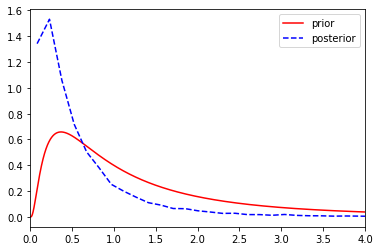

In [68]:
tick = np.arange(x2[:,0].min(), x2[:,0].max(), 0.001)
p, y = np.histogram(x[:,0], bins=100, normed=True)
plt.plot(tick, st.lognorm.pdf(tick,1),'r',label='prior')
y = (y[:-1] + y[1:])/2
plt.plot(y, p, '--b',label='posterior')
plt.xlim(0,4)
plt.legend()
#plt.savefig("1st_dim_of_kappai_by_MH.png")
#files.download("1st_dim_of_kappai_by_MH.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


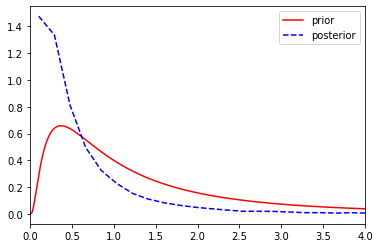

In [65]:
tick = np.arange(x2[:,1].min(), x2[:,1].max(), 0.001)
p, y = np.histogram(x2[:,1], bins=100, normed=True)
plt.plot(tick, st.lognorm.pdf(tick,1),'r',label='prior')
y = (y[:-1] + y[1:])/2
plt.plot(y, p, '--b',label='posterior')
plt.xlim(0,4)
plt.legend()
plt.show()

In [ ]:
t0 = sm.tsa.acf(x2[:,2])
t1 = sm.tsa.acf(x2[:,1])
print(t0)
print(t1)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


[1.         0.91657987 0.84059291 0.76894861 0.70563335 0.64801155
 0.59442262 0.54526043 0.50360606 0.4672733  0.43352022 0.40153247
 0.37086909 0.34322636 0.31702627 0.2925828  0.26985222 0.24929802
 0.23153341 0.21477681 0.19865829 0.18139193 0.16577732 0.15205469
 0.13972205 0.12820512 0.11693488 0.10699348 0.09866056 0.09156869
 0.08529135 0.07872651 0.07150366 0.06509171 0.05897663 0.05349923
 0.04887724 0.04442877 0.04009048 0.03644133 0.03351486]
[1.         0.91472501 0.84058497 0.77393027 0.71381129 0.6605571
 0.60939368 0.562311   0.51827192 0.47987717 0.44514594 0.41180159
 0.38010846 0.34959932 0.32178938 0.29778629 0.27527871 0.25310421
 0.23340001 0.21523003 0.19905595 0.18426851 0.1721058  0.16046971
 0.149384   0.13940054 0.12933185 0.1215424  0.11423743 0.10730735
 0.10127255 0.09474044 0.08843362 0.08233879 0.0773885  0.07311303
 0.07004499 0.06721572 0.06468818 0.06128986 0.05768262]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

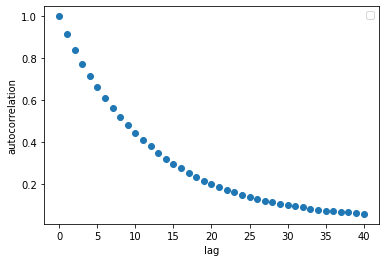

In [ ]:
l = np.arange(len(t1))
plt.scatter(l,t1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.legend()
plt.savefig("atuoco_2nd_dim_by_MH.png")
files.download("atuoco_2nd_dim_by_MH.png")
plt.show()

In [ ]:
plt.scatter(l,t1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('1st dem of 2-dem')

In [ ]:
x6 = MH(100000,9)
x3 = MH(100000,9)
x4 = MH(100000,9)
x5 = MH(100000,9)
D= 10000
J =5
L =100000-D
x20 = x2[D:,0]
x30 = x3[D:,0]
x40 = x4[D:,0]
x50 = x5[D:,0]
x60 = x6[D:,0]   # discard 1st 1000 values

x_2 = np.mean(x20)
x_3 = np.mean(x30)
x_4 = np.mean(x40)
x_5 = np.mean(x50)
x_6 = np.mean(x60) # for each chain, calcu their mean 
xd = (x_2+x_3+x_4+x_5+x_6)/5  # grand mean 
print(xd)
B = L*((x_2-xd)**2+(x_3-xd)**2+(x_4-xd)**2+(x_5-xd)**2+(x_6-xd)**2)/(J-1)   # between chain variance 
print(B)
s2 = np.std(x2)**2
s3 = np.std(x3)**2
s4 = np.std(x4)**2
s5 = np.std(x5)**2
s6 = np.std(x6)**2     # within chain variance 
print(s2,s3,s4,s5,s6)
W = (s2+s3+s4+s5+s6)/5
R= (L-1)*W/L+B/L
R=R/W
R   #GR stats 

[2.6839364  0.95846569 2.22786453 0.40947762 0.64840228 1.24276024
 0.86445234 0.97491395 2.56245216]
reject probablity: 0.63835
[1.94940112 0.22411784 0.26139846 0.24489786 1.18660931 1.36746991
 0.12646819 0.36642576 2.7671304 ]
reject probablity: 0.63734
[0.60277047 2.90957728 1.62625526 0.1914856  1.07377788 1.78568738
 0.21693605 0.07487037 1.17944416]
reject probablity: 0.64064
[0.57739292 1.75401924 1.93398371 0.09878893 0.97934738 1.66821655
 7.38682705 2.55200781 0.16587512]
reject probablity: 0.64072
0.6017744711064529
7.142137723662959
0.5966809886492767 0.6578548666341982 0.5907239213274394 0.6201726933015821 0.6472012685494345


1.0001163646738453

In [ ]:
#########################

In [90]:
def algo1(m,d,d2):
  x = np.zeros((m,d))
  k = 0
  x[0] = np.random.normal(0,1,d)
  #e = np.random.lognormal(0,1,d)
  i = 0
  #print(e)
  data = finite_grid2(d2,0.05) #####
  for j in range(1,m):
    xt = x[j-1]
    y = xt+np.random.normal(0,0.64,d)
    s = np.random.rand(1)
    u = finite_grid2(np.exp(xt),0.1)
    v = finite_grid2(np.exp(y),0.1)
    r = multilognorm(np.exp(y))*np.exp((-np.linalg.norm(data-v))**2/2*10**(-5))/(multilognorm(np.exp(xt))*np.exp((-np.linalg.norm(data-u))**2/2*10**(-5)))
    rd = 1/r                        
    if s >= min(1,r):
      x[j] = xt
      k += 1
    else:
      r = min(1,r)
      rd = min(1,rd)
      u = finite_grid2(np.exp(xt),0.05)
      v = finite_grid2(np.exp(y),0.05)
      r = multilognorm(np.exp(y))*np.exp((-np.linalg.norm(data-v))**2/2*10**(-5)*rd)/(r*multilognorm(np.exp(xt))*np.exp((-np.linalg.norm(data-u))**2/2*10**(-5)))
      ss = np.random.rand(1)
      if ss >= min(1,r):
        x[j] = xt
        i += 1
      else:
       x[j] = y
      
  print('reject probablity: ' + str(k / m))
  x = np.exp(x)
  print(k,i)
  return x

In [91]:
start = datetime.datetime.now()
x = algo1(100000,9,da)
print(datetime.datetime.now()-start)
print(np.mean(x,axis=0))

reject probablity: 0.639
63900 0
0:13:08.955668
[0.61224832 0.57721498 0.59689858 0.59480904 0.61629169 0.61151202
 0.5989059  0.59693042 0.60627496]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


<function matplotlib.pyplot.show(*args, **kw)>

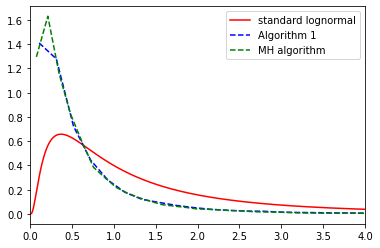

In [87]:
t = np.arange(x[:,3].min(),x[:,3].max(),0.001)
p, y = np.histogram(x[:,3], bins=100, normed=True)
plt.plot(t, st.lognorm.pdf(t,1),'r',label='standard lognormal')
y = (y[:-1] + y[1:])/2
plt.plot(y, p, '--b',label='Algorithm 1')
q, z = np.histogram(x2[:,3],bins=100,normed=True)
z = (z[:-1] + z[1:])/2
plt.plot(z,q,'--g',label='MH algorithm')
plt.xlim(0,4)
plt.legend()
#plt.savefig("comparison_of_dim1new2.png")
#files.download("comparison_of_dim1new2.png")
plt.show


In [71]:
print(sm.tsa.acf(x[:,0]))
print(sm.tsa.acf(x[:,1]))
print(sm.tsa.acf(x[:,2]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


[1.         0.9085522  0.82689545 0.75747718 0.69141506 0.63479464
 0.5843408  0.53615505 0.49050917 0.449369   0.41033388 0.37717577
 0.34866222 0.32213759 0.29822192 0.27710609 0.25694307 0.23602533
 0.21728027 0.2006092  0.18652369 0.17352391 0.16281052 0.15201149
 0.14170343 0.13150438 0.12249004 0.11473925 0.10729507 0.10055011
 0.09392248 0.08780682 0.0820787  0.0755903  0.06999673 0.0637601
 0.05756419 0.05224475 0.04823872 0.04445519 0.04044542]
[1.         0.91984273 0.84197257 0.76654207 0.69892952 0.63673454
 0.5807014  0.53542104 0.49339386 0.45742457 0.42598953 0.39764718
 0.37121998 0.34452107 0.32120673 0.29943513 0.27679073 0.2558746
 0.23400126 0.21397753 0.19442622 0.17724301 0.16208936 0.14889503
 0.13838032 0.12859883 0.12059247 0.11351029 0.10655127 0.09974649
 0.09267823 0.08604539 0.08067845 0.07483951 0.07036658 0.06642416
 0.06231649 0.059312   0.05627157 0.05350376 0.05055175]
[1.         0.91626886 0.84315118 0.77640313 0.71689436 0.66107653
 0.61113772 0.564

In [ ]:
t1 = sm.tsa.acf(x[:,0])
t2 = sm.tsa.acf(x[:,1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

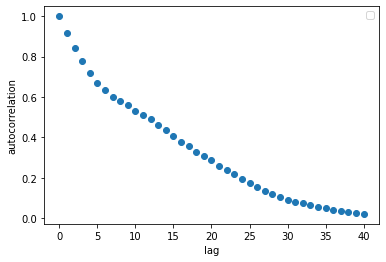

In [ ]:
l = np.arange(len(t2))
plt.scatter(l,t2)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.legend()
plt.savefig("atuoco_2nd_dim_by_Algo1.png")
files.download("atuoco_2nd_dim_by_Algo1.png")
plt.show()

In [76]:
x6 = algo1(100000,9,da)
x3 = algo1(100000,9,da)
x4 = algo1(100000,9,da)
x5 = algo1(100000,9,da)

reject probablity: 0.637
63700 0
reject probablity: 0.63852
63852 0
reject probablity: 0.63897
63897 0
reject probablity: 0.63734
63734 0


In [78]:
D= 10000
J =5
L =100000-D
x21 = x[D:,0]
x31 = x3[D:,1]
x41 = x4[D:,1]
x51 = x5[D:,1]
x61 = x6[D:,1]   # discard 1st 1000 values

x_2 = np.mean(x21)
x_3 = np.mean(x31)
x_4 = np.mean(x41)
x_5 = np.mean(x51)
x_6 = np.mean(x61) # for each chain, calcu their mean 
xd = (x_2+x_3+x_4+x_5+x_6)/5  # grand mean 
print(xd)
B = L*((x_2-xd)**2+(x_3-xd)**2+(x_4-xd)**2+(x_5-xd)**2+(x_6-xd)**2)/(J-1)   # between chain variance 
print(B)
s2 = np.std(x)**2
s3 = np.std(x3)**2
s4 = np.std(x4)**2
s5 = np.std(x5)**2
s6 = np.std(x6)**2     # within chain variance 
print(s2,s3,s4,s5,s6)
W = (s2+s3+s4+s5+s6)/5
R= (L-1)*W/L+B/L
R=R/W
R  

0.5965648960014032
28.795453601342608
0.647850787352493 0.6207470340852569 0.6335135748071913 0.6538599060731171 0.6448142916294066


1.0004886872588021

Text(0.5, 1.0, '1st dem of 2-dem')

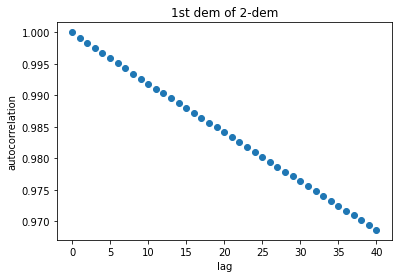

In [ ]:
l = np.arange(len(t1))
plt.scatter(l,t1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('1st dem of 2-dem')

Text(0.5, 1.0, '2nd dem of 2-dem')

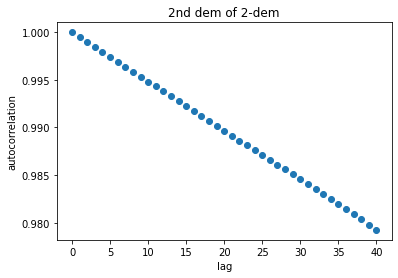

In [ ]:
plt.scatter(l,t3)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('2nd dem of 2-dem')

Text(0.5, 1.0, '2nd dem of 2-dem')

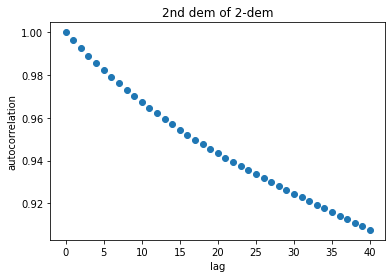

In [ ]:
plt.scatter(l,t4)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('2nd dem of 2-dem')